In [1]:
# Remove warning messages
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

# navigation and read files
import glob
import os

# Read HDF5 binary data format: convenient for large data storage
import h5py

# Read and display images
import matplotlib.pyplot as plt
import imageio
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow import keras

# DL dependancies
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
import tensorflow.keras as keras
import tensorflow as tf


In [2]:
PATH_TO_DATA = 'data/archive/'
CSV_FILES =  ['letters.csv', 'letters2.csv', 'letters3.csv']

def import_data(CSV_FILE):
    data = pd.read_csv(PATH_TO_DATA + CSV_FILE)
    # Create path extention for corresponding folders that contains images
    data['source'] = CSV_FILE[:-4]+'/'
    return data

data1 = import_data(CSV_FILES[0])
data2 = import_data(CSV_FILES[1])
data3 = import_data(CSV_FILES[2])
data = pd.concat([data1, data2, data3], ignore_index=True)

# I won't use these data anymore
del(data1, data2, data3)
data = shuffle(data, random_state = 42)

In [3]:
# Get all labels in one string
letters = ''
for letter in data.letter.unique():
    letters += letter

# Which letter is written on each image
labels = data.label

def ohe_letters(label):
    '''
    One hot encoding for the target label
    '''
    resu = np.zeros(len(letters))
    index = letters.index(label)
    resu[index] = 1
    return resu

def ohe_backgrounds(label):
    '''
    One hot encoding for background column
    '''
    resu = np.zeros(len(data.background.unique()))
    resu[label] = 1
    return resu

data['encoded_letter'] = data['letter'].apply(lambda x:ohe_letters(x))
data['encoded_background'] = data['background'].apply(lambda x:ohe_backgrounds(x))

In [48]:
# Store all png images into one numpy array
images = []
# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# I want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    numpy_image = cv2.imread(os.path.join(PATH_TO_DATA + row['source'], img_name))
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['encoded_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['encoded_background'])

# Normalize array of images
images = np.array(images)/255

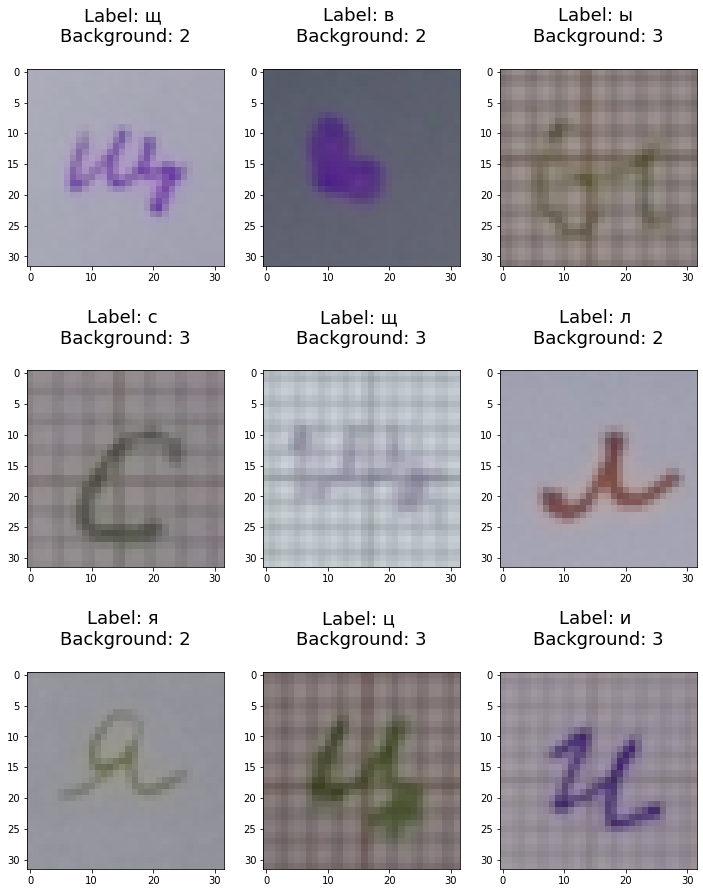

In [5]:
def display_image(images_list, list_of_labels = np.arange(9)):

    # plot first few images
    plt.figure(figsize=(12,12))
    for index in list_of_labels:

        # Get corresponding label
        ohe_label = encoded_labels[index]
        index_letter = list(ohe_label).index(1)
        associated_letter = letters[index_letter]

        # Get background
        associated_background = backgrounds[index]


        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Label: %s \n'%associated_letter+\
                 'Background: %s\n'%associated_background,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(images[index])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

display_image(images)

In [28]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)

In [7]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(letters)
# Group of training samples
BATCH_SIZE = 64
# Number of complete presentations of the dataset to be learned
EPOCHS = 100

def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [8]:
def CNN_model(activation = 'softmax',
              loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', top_3_categorical_accuracy]):

    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))

    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

    return model

In [9]:
cnn_model = CNN_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.letters.hdf5',
                               verbose = 2,
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=2,
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=2)

# Training
history = cnn_model.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpointer, lr_reduction, estopping])

Epoch 1/100
178/178 [==============================] - 41s 228ms/step - loss: 3.4615 - accuracy: 0.0439 - top_3_categorical_accuracy: 0.1234 - val_loss: 2.6653 - val_accuracy: 0.2546 - val_top_3_categorical_accuracy: 0.4870

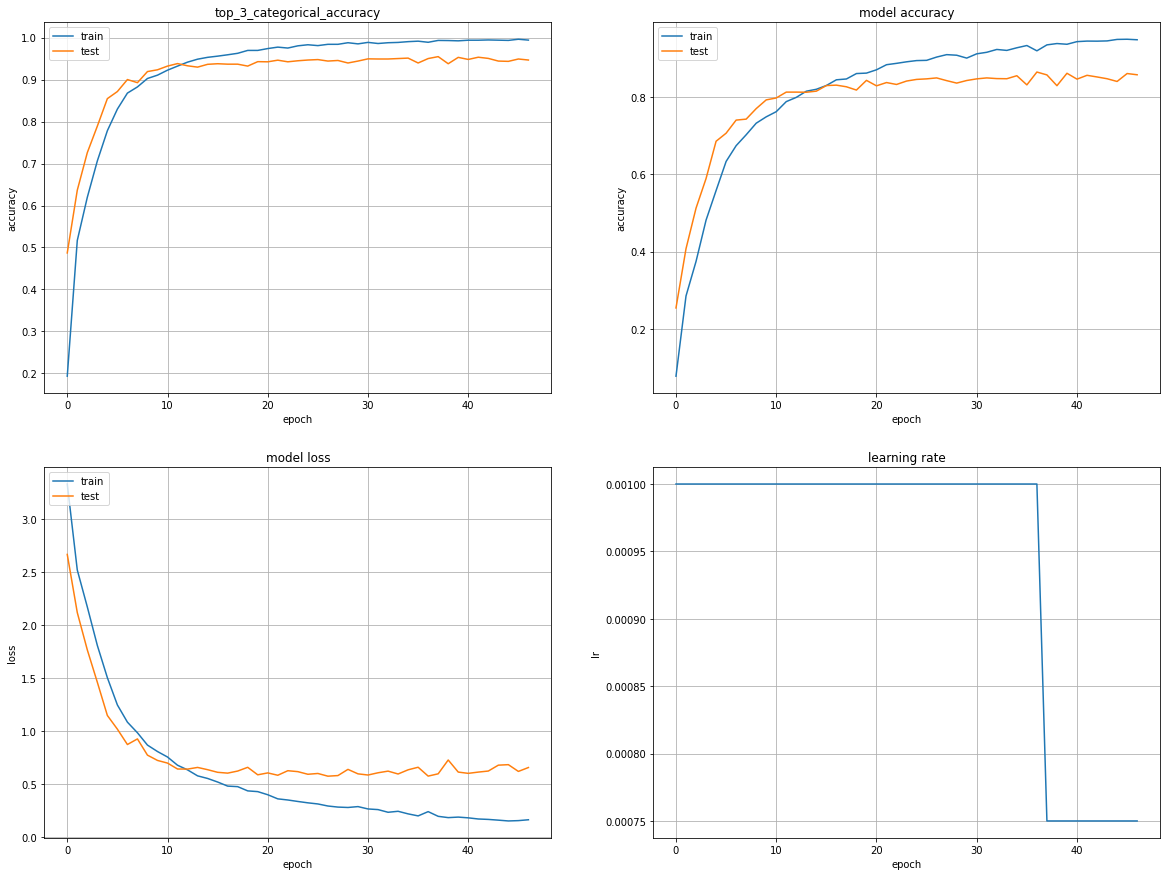

In [10]:
def plot_history(model_history):
    plt.figure(figsize = (20,15))

    plt.subplot(221)
    # summarize history for accuracy
    plt.plot(model_history.history['top_3_categorical_accuracy'])
    plt.plot(model_history.history['val_top_3_categorical_accuracy'])
    plt.title('top_3_categorical_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    plt.subplot(222)
    # summarize history for accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    plt.subplot(223)
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    plt.subplot(224)
    # summarize history for lr
    plt.plot(model_history.history['lr'])
    plt.title('learning rate')
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.grid()

    plt.show()

plot_history(history)

In [30]:
# loading the model with the best validation accuracy
cnn_model.load_weights('weights.best.letters.hdf5')
cnn_model.evaluate(X_val, y_val)
def load_image(path_filename):
	# load the image
	img = load_img(path_filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

current = 'letters/01_01.png'

89/89 [==============================] - 1s 13ms/step - loss: 0.5746 - accuracy: 0.8487 - top_3_categorical_accuracy: 0.9443

predicted: а
true label: а


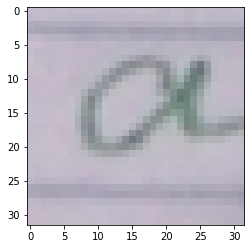

In [35]:
img = load_image(PATH_TO_DATA+current)

# predict the class
a_letter = cnn_model.predict_classes(img)

plt.imshow(img[0])
print('predicted:', letters[a_letter[0]])
print('true label:', get_true_label(PATH_TO_DATA+current, data, 'letter'))

def single(current):
    img = load_image(PATH_TO_DATA+current)

    # predict the class
    a_letter = cnn_model.predict_classes(img)
    a_background_letter = background_model.predict_classes(image)
    plt.figure(0)
    plt.imshow(img[0])
    print('predicted:', letters[a_letter[0]])
    print('true label:', get_true_label(PATH_TO_DATA+current, data, 'letter'))
    print('predicted_b:', backgrounds[a_background_letter[0]])
    print('true label_b:', get_true_label(PATH_TO_DATA+current, data, 'background'))
    return a_letter, a_background_letter

In [47]:
def load_random_images(number_of_images_to_load = 9):
    imagesx = []
    true_labels = []
    true_backgrounds = []

    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = PATH_TO_DATA+'letters/'
        else:
            path = PATH_TO_DATA+'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))

        index_image = random.randint(0, len(os.listdir(path)))

        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        imagesx.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)

    return imagesx, true_labels, true_backgrounds

def classes_predictions(images_list_to_classify, true_labels, model):

    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):

        a_letter = model.predict_classes(image)
        associated_letter = letters[a_letter[0]]

        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)

    # show the figure
    plt.show()

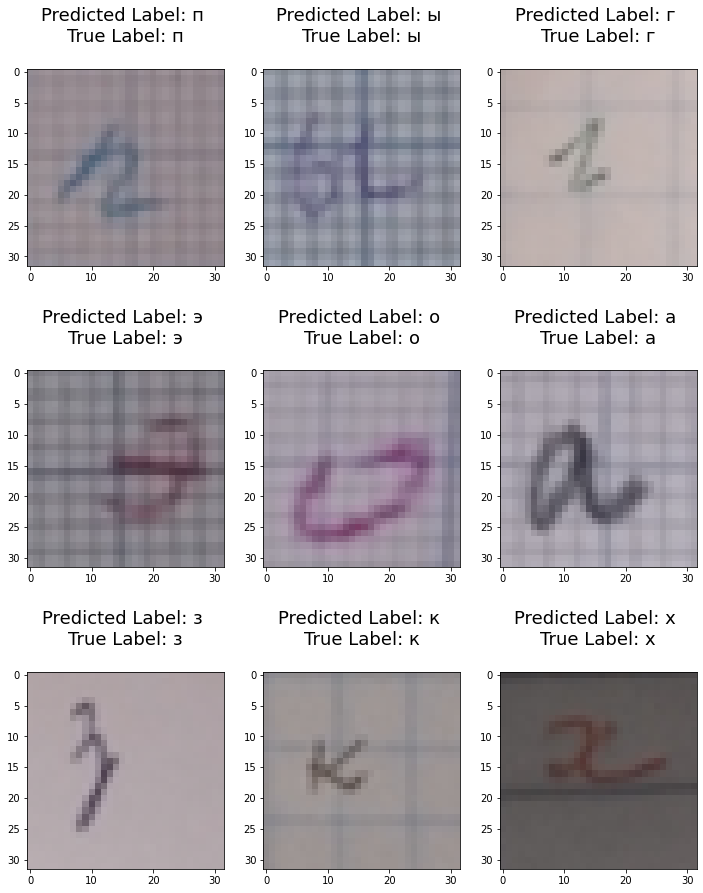

In [14]:
test_images, true_labels, true_backgrounds = load_random_images()
classes_predictions(test_images, true_labels, cnn_model)

In [15]:
X = np.array(images.copy())
y = np.array(encoded_backgrounds.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(set(backgrounds))
# Group of training samples
BATCH_SIZE = 32
# Number of complete presentations of the dataset to be learned
EPOCHS = 100

def CNN_back_model(activation = 'softmax',
              loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', top_3_categorical_accuracy]):

    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))

    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

    return model

In [16]:
# Init CNN model
background_model = CNN_back_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.back.hdf5',
                               verbose = 2,
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=2,
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=2)

# Training
history_background = background_model.fit(X_train, y_train,
                                          batch_size = BATCH_SIZE,
                                          epochs = EPOCHS,
                                          verbose = 1,
                                          validation_data = (X_val, y_val),
                                          callbacks = [checkpointer, lr_reduction, estopping])

Epoch 1/100
355/355 [==============================] - 23s 65ms/step - loss: 0.7948 - accuracy: 0.6799 - top_3_categorical_accuracy: 0.9453 - val_loss: 0.2690 - val_accuracy: 0.9062 - val_top_3_categorical_accuracy: 0.9926

In [17]:
# loading the model with the best validation accuracy
background_model.load_weights('weights.best.back.hdf5')
background_model.evaluate(X_val, y_val)

def improved_classes_predictions(images_list_to_classify, true_labels, true_backgrounds, letter_model, backg_model):

    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):

        a_letter = letter_model.predict_classes(image)
        associated_letter = letters[a_letter[0]]

        a_background_letter = backg_model.predict_classes(image)

        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index]+\
                  'Predicted Background: %s\n'%a_background_letter[0]+\
                  'True Background: %s\n'%true_backgrounds[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)

    # show the figure
    plt.show()

89/89 [==============================] - 1s 14ms/step - loss: 0.0184 - accuracy: 0.9954 - top_3_categorical_accuracy: 0.9996

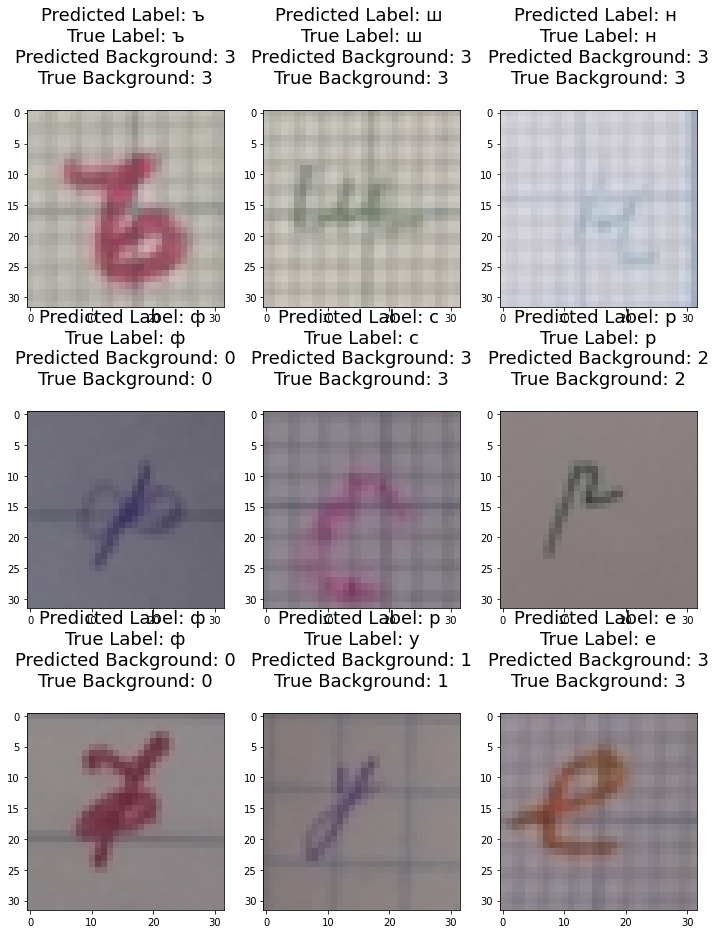

In [18]:
test_images, true_labels, true_backgrounds = load_random_images()
improved_classes_predictions(test_images, true_labels, true_backgrounds, cnn_model, background_model)

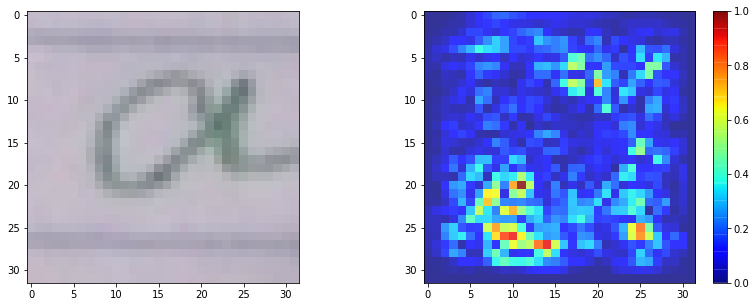

In [32]:
current = 'letters/01_01.png'

img = load_image(PATH_TO_DATA+current)
imagesx = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = cnn_model(imagesx, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]

grads = tape.gradient(loss, imagesx)

_img = keras.preprocessing.image.load_img(PATH_TO_DATA+current,target_size=(32, 32))
dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(_img)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

In [33]:
def saliency_single(current):
    img = load_image(PATH_TO_DATA+current)
    imagesx = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = cnn_model(imagesx, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, imagesx)

    _img = keras.preprocessing.image.load_img(PATH_TO_DATA+current,target_size=(32, 32))
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    ## normalize to range between 0 and 1
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    plt.figure(1)
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.show()

def saliency_single_back(current):
    img = load_image(PATH_TO_DATA+current)
    imagesx = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = background_model(imagesx, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]

    grads = tape.gradient(loss, imagesx)

    _img = keras.preprocessing.image.load_img(PATH_TO_DATA+current,target_size=(32, 32))
    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    ## normalize to range between 0 and 1
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

    plt.figure(1)
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.show()

predicted: а
true label: а
predicted_b: 2
true label_b: 0


  0%|          | 0/100 [00:00<?, ?it/s]

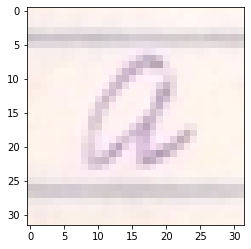

In [43]:
current = current = 'letters/01_09.png'

from lime.lime_image import LimeImageExplainer
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries

pred, pred2 = single(current)

image_raw = load_img(PATH_TO_DATA+current, target_size=(32,32))
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
image = np.double(image)
img = load_image(PATH_TO_DATA+current)
explainer = LimeImageExplainer()
explanation = explainer.explain_instance(image[0], cnn_model.predict,
                                         top_labels=2, num_samples=100,
                                         random_seed=42)
temp, mask = explanation.get_image_and_mask(pred[0], positive_only=True, num_features=20, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [44]:
def lime_single(current, prediction):
    image_raw = load_img(PATH_TO_DATA+current, target_size=(32,32))
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    image = np.double(image)
    img = load_image(PATH_TO_DATA+current)
    explainer = LimeImageExplainer()
    explanation = explainer.explain_instance(image[0], cnn_model.predict,
                                             top_labels=2, num_samples=100,
                                             random_seed=42)
    temp, mask = explanation.get_image_and_mask(prediction[0], positive_only=True, num_features=20, hide_rest=True)
    # plot image and mask together
    plt.figure(2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()

def lime_single_back(current, prediction):
    image_raw = load_img(PATH_TO_DATA+current, target_size=(32,32))
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    image = np.double(image)
    img = load_image(PATH_TO_DATA+current)
    explainer = LimeImageExplainer()
    explanation = explainer.explain_instance(image[0], background_model.predict,
                                             top_labels=2, num_samples=100,
                                             random_seed=42)
    temp, mask = explanation.get_image_and_mask(prediction[0], positive_only=True, num_features=20, hide_rest=True)
    # plot image and mask together
    plt.figure(2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()

In [49]:
from path_explain import PathExplainerTF, scatter_plot, summary_plot, softplus_activation
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

In [50]:
explainer = PathExplainerTF(cnn_model)
attributions1 = explainer.attributions(inputs=X_val,
                                      baseline=X_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)


100%|██████████| 2836/2836 [25:25<00:00,  1.86it/s]


In [51]:
from path_explain import PathExplainerTF, scatter_plot, summary_plot, softplus_activation
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

exp_model = tf.keras.models.clone_model(cnn_model)
exp_model.set_weights(cnn_model.get_weights())
exp_model.layers[0].activation = softplus_activation(beta=10.0)
exp_model.layers[1].activation = softplus_activation(beta=10.0)
exp_model.layers[2].activation = softplus_activation(beta=10.0)
exp_model.layers[6].activation = softplus_activation(beta=10.0)

explainer = PathExplainerTF(exp_model)
attributions2 = explainer.attributions(inputs=X_val,
                                      baseline=X_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)


100%|██████████| 2836/2836 [35:21<00:00,  1.34it/s]


In [ ]:
from path_explain import PathExplainerTF, scatter_plot, summary_plot, softplus_activation
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

exp_back_model = tf.keras.models.clone_model(background_model)
exp_back_model.set_weights(background_model.get_weights())
exp_back_model.layers[0].activation = softplus_activation(beta=10.0)
exp_back_model.layers[1].activation = softplus_activation(beta=10.0)
exp_back_model.layers[2].activation = softplus_activation(beta=10.0)
exp_back_model.layers[6].activation = softplus_activation(beta=10.0)

explainer = PathExplainerTF(exp_back_model)
attributions3 = explainer.attributions(inputs=X_val,
                                      baseline=X_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)


 68%|██████▊   | 1916/2836 [24:36<11:49,  1.30it/s]

In [ ]:
from path_explain import PathExplainerTF, scatter_plot, summary_plot, softplus_activation
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify = y,
                                                  random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

explainer = PathExplainerTF(background_model)
attributions4 = explainer.attributions(inputs=X_val,
                                      baseline=X_train,
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

In [57]:
import shap

index = 20
shap.image_plot(attributions4[index:index+5, :, :], -X_val[index:index+5, :, :])

NameError: name 'attributions4' is not defined

predicted: а
true label: а
predicted_b: 2
true label_b: 0


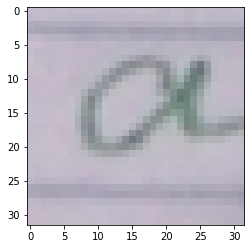

<Figure size 432x288 with 0 Axes>

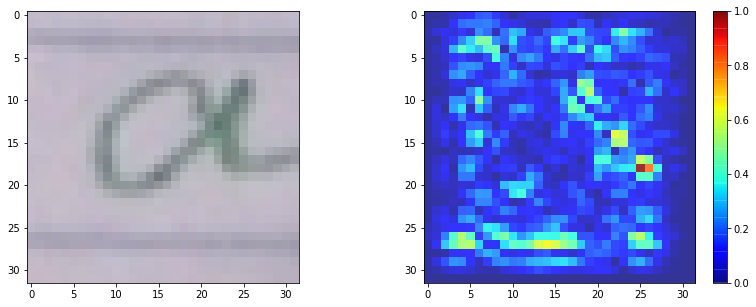

  0%|          | 0/100 [00:00<?, ?it/s]

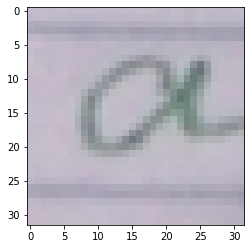

<Figure size 432x288 with 0 Axes>

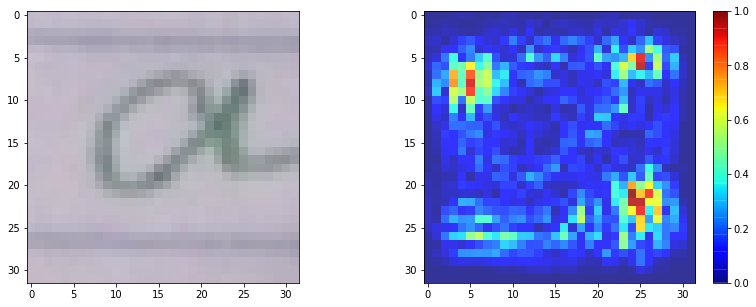

  0%|          | 0/100 [00:00<?, ?it/s]

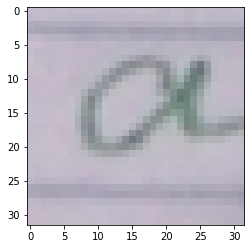

In [83]:
current = 'letters/01_01.png'

pred, back_pred = single(current)
saliency_single(current)
lime_single(current, pred)
saliency_single_back(current)
lime_single_back(current, back_pred)

In [62]:
letters_num = ''
base = 'letters' + letters_num + '/01_0'
end = '.png'

start = 1
stop = 1
for x in range(start, stop):
    current = base + str(x) + end
    print(current)
    pred, back_pred = single(current)
    saliency_single(current)
    lime_single(current, pred)

